# Visualisations et classification sur le dataset Covertype (sans oversampling ou undersampling)

### Récupération des données

In [25]:
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from umap import ParametricUMAP
import umap
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [11]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data
X = covertype.data.features
y = covertype.data.targets

In [12]:
print(X.shape)
print(y.shape)
print("Distribution des classe:",y.Cover_Type.value_counts())

(581012, 54)
(581012, 1)
Distribution des classe: Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


### Réduction du dataset (car trop de données à traiter)

In [14]:
# Réduire la taille de la base de donnée en prenant des échantillons au hasard
new_size = 0.5      # pourcentage des données qu'on garde

if new_size < 1:
    X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=new_size, stratify=y, random_state=42)
else: #si on prend tout le dataset, pas besoin de split
    X_sampled = X
    y_sampled = y
    
print(X_sampled.shape)
print("Nouvelle distribution des classe:",y_sampled.Cover_Type.value_counts())

(290506, 54)
Nouvelle distribution des classe: Cover_Type
2    141650
1    105920
3     17877
7     10255
6      8684
5      4746
4      1374
Name: count, dtype: int64


### Standardisation

In [15]:
### Standardiser données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sampled)

### Visualisation avec UMAP

In [16]:
### Algorithme UMAP
# Hyperparamètres (défaut: 5, 0.1, 2)
n_neighbors = 5
min_dist = 0.1
n_components = 2 # 2 pour 2D, 3 pour 3D

reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
embedding = reducer.fit_transform(X_scaled)
embedding.shape

C:\Users\helen\source\repos_git\TP2-Apprentissage_automatique\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(290506, 2)

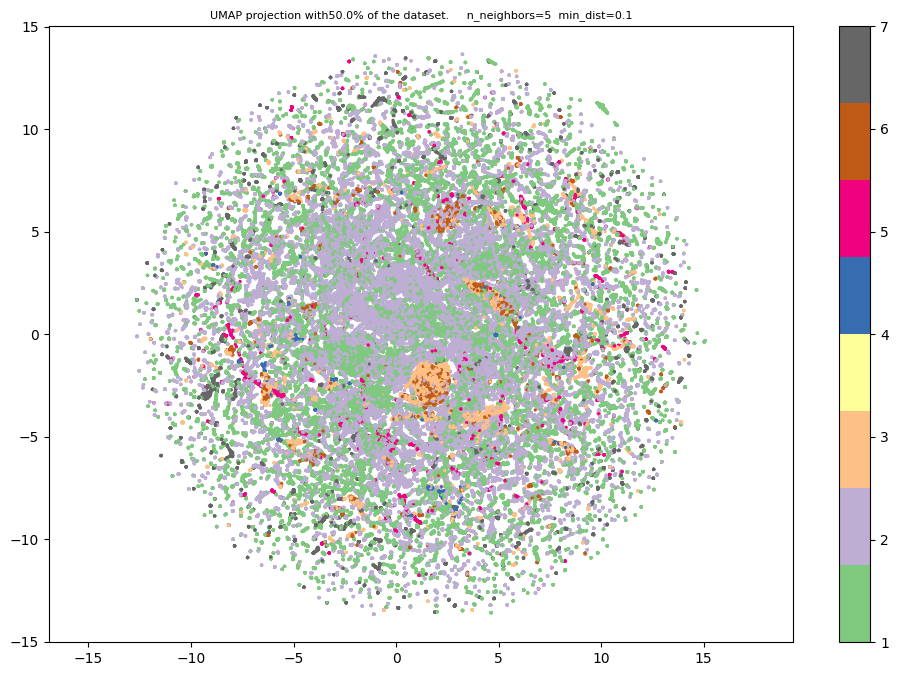

In [22]:
# Affichage du graph

if n_components == 3: # Affichage en 3D    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y_sampled.Cover_Type, s=1)
    # Ajout de la colorbar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=10)
    cbar.set_label("Cover Type", fontsize=8)
    
elif n_components == 2: # Affichage en 2D
    plt.figure(figsize=(12,8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y_sampled.Cover_Type, cmap='tab10', s=2)
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar()
    #plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
    
    hour = dt.datetime.now().time()
    hour = (str(hour)).replace(":", "-")
    
    plt.title("UMAP projection with" + str(new_size*100) + "% of the dataset.   " + "  n_neighbors="+ str(n_neighbors) + "  min_dist="+ str(min_dist), fontsize=8)

### Visualisation avec T-SNE

In [35]:
# Application de T-SNE pour réduire à 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

KeyboardInterrupt: 

In [ ]:
# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sampled, cmap='tab10', s=5)
plt.colorbar(scatter, label='Type de Couverture')
plt.title("Visualisation des classes avec T-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Classification avec Random Forest

In [29]:
y_sampled = y_sampled.values.ravel()  # Convertir en tableau unidimensionnel

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sampled, test_size=0.3, stratify=y_sampled, random_state=42
)

In [30]:
# Créer le pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entraîner le pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [31]:
# Prédire sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

In [33]:
# Afficher les résultats finaux
print("Résultats :")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")

Résultats :
Accuracy : 0.9344
F1-Score : 0.9339


In [36]:
print("\nRapport de classification détaillé :\n")
print(classification_report(y_test, y_pred))


Rapport de classification détaillé :

              precision    recall  f1-score   support

           1       0.95      0.92      0.93     31776
           2       0.93      0.96      0.94     42495
           3       0.91      0.95      0.93      5363
           4       0.90      0.79      0.84       412
           5       0.91      0.67      0.78      1424
           6       0.91      0.84      0.87      2605
           7       0.97      0.92      0.95      3077

    accuracy                           0.93     87152
   macro avg       0.93      0.87      0.89     87152
weighted avg       0.93      0.93      0.93     87152

